In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import os
import torch.nn.init as init
from torchvision import datasets, transforms
from torch import optim, nn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import logging
import math
import copy

/Users/dongpochen/opt/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dir = './output'

In [3]:
def adjust_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.75 * param_group['lr']

# Dataloader

In [4]:
tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

In [5]:
def task_dataloader(task_num):
    task_dir = {0: [0, 1], 1: [2, 3], 2: [4, 5], 3: [6, 7], 4:[8, 9]}

    train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=tf)

    indices = [i for i, (_, label) in enumerate(train_dataset) if label in task_dir[task_num]]
    dataset = Subset(train_dataset, indices)
    task_train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    indices = [i for i, (_, label) in enumerate(test_dataset) if label in task_dir[task_num]]
    dataset = Subset(test_dataset, indices)
    task_test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return task_train_loader, task_test_loader

def load_all_data():
    train_dataset = datasets.MNIST(root='./data', train=True, transform=tf, download=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, test_loader

In [6]:
train_loader, test_loader = load_all_data()
task_dataloaders = {}
for task in range(0, 5):
    train_dl, test_ld = task_dataloader(task)
    task_dataloaders[task] = (train_dl, test_ld)

# Model

In [7]:
class DeepModelWithAttention(nn.Module):
    def __init__(self, desired_sum):
        super(DeepModelWithAttention, self).__init__()
        self.desired_sum = desired_sum

        self.attn = nn.MultiheadAttention(embed_dim=2, num_heads= 1)
        self.fc = nn.Linear(2, 1)
        
    def forward(self, x):
        attn_output, _ = self.attn(x, x, x)
        attn_output = attn_output.mean(dim = 1)
        output = self.fc(attn_output).squeeze(-1) 
        
        output = F.softmax(output, dim = 0) * self.desired_sum

        return output

In [8]:
class MLP_Enhance(nn.Module):
    def __init__(self, out_dim=10, in_channel=1, img_sz=28, hidden_dim=400):
        super(MLP_Enhance, self).__init__()
        self.in_dim = in_channel*img_sz*img_sz
        self.linear = nn.Sequential(
            nn.Linear(self.in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
        )
        self.last = nn.Sequential(
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax(dim=1)
        )
        self.init_weights()

    def init_weights(self):
        for layer in self.linear:
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                init.constant_(layer.bias, 0)
        last_linear = self.last[0]
        init.xavier_normal_(last_linear.weight)
        init.constant_(last_linear.bias, 0)


    def features(self, x):
        x = self.linear(x.view(-1,self.in_dim))
        return x

    def logits(self, x):
        x = self.last(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x

In [9]:
def cal_acc(model, dataloader, device):
    model.eval()
    correct, total = 0., 0.
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [10]:
def plot_acc_history(all_accuracies):
    plt.figure(figsize=(18, 12))

    for i, task_accuracies in enumerate(all_accuracies):
        plt.subplot(2, 3, i+1)
        for task, accs in task_accuracies.items():
            plt.plot(accs,'-', label=f'Task {task}')
        plt.title(f'Accuracy per Mini-Batch for Task {i}')
        plt.xlabel('Mini-Batch Number')
        plt.ylabel('Accuracy (%)')
        plt.ylim(-5, 105)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


def plot_task_acc_history(all_accuracies, save_name, epochs):
    for task in [0, 1, 2, 3, 4]:
        if (task == 0):
            task_history = []
        else:
            task_history =  [0] * (epochs * task)
        for i, task_accuracies in enumerate (all_accuracies):
            if (i >= task):
                task_history.extend(task_accuracies[task])
                    
        plt.plot(task_history, '-', label=f'Task {task}')

    plt.xlabel('Mini-Batch Number')
    plt.ylabel('Accuracy (%)')
    plt.ylim(-5, 105)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_name) 
    plt.show()

# Train Function

In [11]:
def pretrain_meta(meta_model, optimizer_M, task_num):
    target = torch.full((task_num, 1, 1), 2.0).to(device)
    criterion = nn.MSELoss()

    print("Pretrain on meta_model")
    for epoch in range(400):
        prev_outputs = None
        for k in range (task_num):
            past_output = F.softmax(torch.rand(batch_size, 10), dim=-1).to(device)
            outputs = F.softmax(torch.rand(batch_size, 10), dim=-1).to(device)
            diff = past_output[:,k*2:k * 2 + 2] - outputs[:,k*2:k * 2 + 2]
            diff = diff.unsqueeze(0)
            if (prev_outputs == None):
                prev_outputs = diff
            else:
                prev_outputs = torch.cat((prev_outputs, diff), dim=0)

        meta_out = meta_model(prev_outputs).view(-1, 1, 1 )

        meta_model.train()
        optimizer_M.zero_grad()
        loss = criterion(meta_out, target)
        loss.backward()
        optimizer_M.step()
        
        '''if((epoch + 1) % 100 == 0):
            print(f'Epoch [{epoch+1}/{400}], Loss: {loss.item():.4f}')'''

In [12]:
task_num = 1
meta_model = DeepModelWithAttention(desired_sum = 2 * task_num).to(device)
optimizer_M = optim.Adam(meta_model.parameters(), lr=0.001)
pretrain_meta(meta_model, optimizer_M, task_num)

Pretrain on meta_model


In [13]:
s = torch.rand(4, 2)

a = torch.rand(4, 2)
b = torch.rand(4, 2)
c = torch.rand(4, 2)

l1 = 2 * torch.mean(torch.abs(a - s)) + 2 * torch.mean(torch.abs(b - s)) + 2 * torch.mean(torch.abs(c - s))
print(l1)

tensor(2.4168)


In [14]:
diff_1 = torch.abs(a - s)
diff_2 = torch.abs(b - s)
diff_3 = torch.abs(c - s)

diff_1 = diff_1.unsqueeze(0)
diff_2 = diff_2.unsqueeze(0)
diff_3 = diff_3.unsqueeze(0)

diff = torch.cat((diff_1, diff_2), dim=0)
diff = torch.cat((diff, diff_3), dim=0)

print(diff.size())
mean_diff = torch.mean(diff, dim = (1, 2))
l2 = torch.sum(2 * mean_diff)
print(l2)

torch.Size([3, 4, 2])
tensor(2.4168)


In [24]:
def train(model, task_num, criterion, optimizer, prev_models, task_dataloaders, epoches = 4):
    train_loader = task_dataloaders[task_num][0]
    task_accuracies = {task: [] for task in range(task_num + 1)}
    distribution_factor  = 20

    if (task_num != 0):
        meta_model = DeepModelWithAttention(desired_sum = 2 * task_num).to(device)
        optimizer_M = optim.Adam(meta_model.parameters(), lr=0.001)
        pretrain_meta(meta_model, optimizer_M, task_num)
    
    valid_out_dim = task_num * 2 + 2
    logging.info(f"##########Task {task_num}##########")
    for e in range(epoches):
        logging.info(f"Epoch {e}")
        batch_num = 0
        for images, labels in train_loader:
            model.train()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            random_data = torch.rand(256, 1, 28, 28).to(device)
            random_data = (random_data - 0.5) / 0.5
            random_target = torch.randint(0, 10, (256,), dtype=torch.int64).to(device)
            fake_output = model(random_data)
            dis_loss = distribution_factor * criterion(fake_output, random_target)

            reg_loss = 0
            prev_outputs = None
            
            if (task_num != 0):
                meta_model.eval()
                for k, prev_mod in enumerate(prev_models):
                    with torch.no_grad():
                        past_output = prev_mod(images)
                    diff = torch.abs(past_output[:,k*2:k * 2 + 2] - outputs[:,k*2:k * 2 + 2])
                    diff = diff.unsqueeze(0)
                    if (prev_outputs == None):
                        prev_outputs = diff
                    else:
                        prev_outputs = torch.cat((prev_outputs, diff), dim=0)

                with torch.no_grad():
                    meta_out = meta_model(prev_outputs).view(-1, 1, 1)
                    
                mean_diff = torch.mean(prev_outputs, dim = (1, 2))
                reg_loss = torch.sum(meta_out * mean_diff)
                
                if (batch_num == 0):
                    # print(meta_out)
                    print(mean_diff)
            
            classifiaction_loss = criterion(outputs[:,:valid_out_dim], labels) 
                    
            loss = classifiaction_loss + dis_loss + reg_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            '''if (task_num != 0):
                meta_model.train()
                prev_outputs = None
                with torch.no_grad():
                    outputs = model(images)
                for k, prev_mod in enumerate(prev_models):
                    with torch.no_grad():
                        past_output = prev_mod(images)
                    
                    diff = torch.abs(past_output[:,k*2:k * 2 + 2] - outputs[:,k*2:k * 2 + 2])
                    diff = diff.unsqueeze(0)
                    if (prev_outputs == None):
                        prev_outputs = diff
                    else:
                        prev_outputs = torch.cat((prev_outputs, diff), dim=0)

                meta_out = meta_model(prev_outputs).view(-1, 1, 1)

                mean_diff = torch.mean(prev_outputs, dim = (1, 2))
                meta_loss = torch.sum(meta_out * mean_diff)

                optimizer_M.zero_grad()
                meta_loss.backward()
                optimizer_M.step()'''

            batch_num += 1

        avg_acc = 0
        log_message = []
        log_message.append(f"Epoch: {e}, ")
        for task in range(task_num + 1):
            acc = cal_acc(model, task_dataloaders[task][0], device)
            avg_acc += acc
            task_accuracies[task].append(acc * 100)
            log_message.append(f"Task {task} acc: {acc * 100:.4f}")

        logging.info(', '.join(log_message) + f", Task avg acc:{avg_acc*100/(task_num + 1):.4f}")
        if(task_num != 0):
            logging.info(f'loss:{loss.item()}, c_loss: {classifiaction_loss: .4f}, reg_loss:{reg_loss:.4f}')
    
    return task_accuracies

# Train

In [25]:
def setup_logging(file_name):
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s - %(levelname)s - %(message)s',
                        handlers=[
                            logging.FileHandler(file_name),
                            logging.StreamHandler()
                        ],
                        force=True)
    

def train_split_task(task_name, task_dataloaders):
    print(f"Training on {task_name}")
    prev_models = []
    model = MLP_Enhance()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
    criterion = nn.CrossEntropyLoss()

    epochs, lr = 4, 0.005
    file_name = f"{output_dir}/{task_name}_epochs={epochs}"
    log_file_name = file_name + '.log'
    img_file_name = file_name + '.png'

    setup_logging(log_file_name)
    all_accuracies = []
    for task in [0, 1, 2, 3, 4]:
        task_accuracies = train(model, task, criterion, optimizer, prev_models, task_dataloaders, epoches = epochs)
        all_accuracies.append(task_accuracies)
        prev_models.append(copy.deepcopy(model))

    plot_task_acc_history(all_accuracies, img_file_name, epochs)

2024-06-02 10:16:07,758 - INFO - ##########Task 0##########
2024-06-02 10:16:07,760 - INFO - Epoch 0


Training on 0


2024-06-02 10:16:16,827 - INFO - Epoch: 0, , Task 0 acc: 93.0564, Task avg acc:93.0564
2024-06-02 10:16:16,829 - INFO - Epoch 1
2024-06-02 10:16:26,309 - INFO - Epoch: 1, , Task 0 acc: 96.9069, Task avg acc:96.9069
2024-06-02 10:16:26,310 - INFO - Epoch 2
2024-06-02 10:16:35,780 - INFO - Epoch: 2, , Task 0 acc: 97.9512, Task avg acc:97.9512
2024-06-02 10:16:35,782 - INFO - Epoch 3
2024-06-02 10:16:45,238 - INFO - Epoch: 3, , Task 0 acc: 97.9034, Task avg acc:97.9034


Pretrain on meta_model


2024-06-02 10:16:46,223 - INFO - ##########Task 1##########
2024-06-02 10:16:46,224 - INFO - Epoch 0


tensor([[[2.]]])
tensor([0.0847], grad_fn=<MeanBackward1>)


2024-06-02 10:16:59,314 - INFO - Epoch: 0, , Task 0 acc: 85.3555, Task 1 acc: 84.9900, Task avg acc:85.1728
2024-06-02 10:16:59,317 - INFO - loss:47.17885208129883, reg_loss:0.1346
2024-06-02 10:16:59,319 - INFO - Epoch 1


tensor([[[2.]]])
tensor([0.0762], grad_fn=<MeanBackward1>)


2024-06-02 10:17:12,994 - INFO - Epoch: 1, , Task 0 acc: 67.7854, Task 1 acc: 77.4102, Task avg acc:72.5978
2024-06-02 10:17:12,997 - INFO - loss:47.15931701660156, reg_loss:0.1534
2024-06-02 10:17:12,998 - INFO - Epoch 2


tensor([[[2.]]])
tensor([0.0834], grad_fn=<MeanBackward1>)


2024-06-02 10:17:25,906 - INFO - Epoch: 2, , Task 0 acc: 57.3661, Task 1 acc: 92.8191, Task avg acc:75.0926
2024-06-02 10:17:25,907 - INFO - loss:47.10131072998047, reg_loss:0.1724
2024-06-02 10:17:25,908 - INFO - Epoch 3


tensor([[[2.]]])
tensor([0.1082], grad_fn=<MeanBackward1>)


2024-06-02 10:17:38,695 - INFO - Epoch: 3, , Task 0 acc: 61.7746, Task 1 acc: 88.7051, Task avg acc:75.2398
2024-06-02 10:17:38,697 - INFO - loss:47.25305938720703, reg_loss:0.1654


Pretrain on meta_model


2024-06-02 10:17:39,985 - INFO - ##########Task 2##########
2024-06-02 10:17:39,987 - INFO - Epoch 0


tensor([[[2.0000]],

        [[2.0000]]])
tensor([0.1008, 0.0950], grad_fn=<MeanBackward1>)


2024-06-02 10:17:55,724 - INFO - Epoch: 0, , Task 0 acc: 79.4404, Task 1 acc: 67.6031, Task 2 acc: 44.1810, Task avg acc:63.7415
2024-06-02 10:17:55,726 - INFO - loss:48.73862838745117, reg_loss:0.5964
2024-06-02 10:17:55,727 - INFO - Epoch 1


tensor([[[2.0000]],

        [[2.0000]]])
tensor([0.0717, 0.0656], grad_fn=<MeanBackward1>)


2024-06-02 10:18:11,373 - INFO - Epoch: 1, , Task 0 acc: 72.3772, Task 1 acc: 62.9239, Task 2 acc: 35.8746, Task avg acc:57.0586
2024-06-02 10:18:11,375 - INFO - loss:48.590431213378906, reg_loss:0.6256
2024-06-02 10:18:11,376 - INFO - Epoch 2


tensor([[[2.0000]],

        [[2.0000]]])
tensor([0.0655, 0.0753], grad_fn=<MeanBackward1>)


2024-06-02 10:18:27,007 - INFO - Epoch: 2, , Task 0 acc: 68.7022, Task 1 acc: 62.0761, Task 2 acc: 34.6354, Task avg acc:55.1379
2024-06-02 10:18:27,008 - INFO - loss:48.47640609741211, reg_loss:0.5862
2024-06-02 10:18:27,010 - INFO - Epoch 3


tensor([[[2.0000]],

        [[2.0000]]])
tensor([0.0667, 0.0656], grad_fn=<MeanBackward1>)


2024-06-02 10:18:42,742 - INFO - Epoch: 3, , Task 0 acc: 79.3846, Task 1 acc: 55.9009, Task 2 acc: 33.2435, Task avg acc:56.1763
2024-06-02 10:18:42,744 - INFO - loss:48.57704544067383, reg_loss:0.6088


Pretrain on meta_model


2024-06-02 10:18:44,135 - INFO - ##########Task 3##########
2024-06-02 10:18:44,137 - INFO - Epoch 0


tensor([[[2.0000]],

        [[2.0000]],

        [[2.0000]]])
tensor([0.0823, 0.1982, 0.1208], grad_fn=<MeanBackward1>)


2024-06-02 10:19:04,056 - INFO - Epoch: 0, , Task 0 acc: 88.4008, Task 1 acc: 56.6406, Task 2 acc: 18.3190, Task 3 acc: 30.7812, Task avg acc:48.5354
2024-06-02 10:19:04,057 - INFO - loss:49.4587516784668, reg_loss:1.0631
2024-06-02 10:19:04,058 - INFO - Epoch 1


tensor([[[2.0000]],

        [[2.0000]],

        [[2.0000]]])
tensor([0.0741, 0.0822, 0.0302], grad_fn=<MeanBackward1>)


2024-06-02 10:19:23,927 - INFO - Epoch: 1, , Task 0 acc: 73.9238, Task 1 acc: 54.9451, Task 2 acc: 20.9142, Task 3 acc: 20.6908, Task avg acc:42.6185
2024-06-02 10:19:23,930 - INFO - loss:49.38512420654297, reg_loss:1.0600
2024-06-02 10:19:23,931 - INFO - Epoch 2


tensor([[[2.0000]],

        [[2.0000]],

        [[2.0000]]])
tensor([0.0697, 0.0677, 0.0266], grad_fn=<MeanBackward1>)


2024-06-02 10:19:46,248 - INFO - Epoch: 2, , Task 0 acc: 70.7669, Task 1 acc: 46.6838, Task 2 acc: 19.8006, Task 3 acc: 21.7270, Task avg acc:39.7446
2024-06-02 10:19:46,251 - INFO - loss:49.40155792236328, reg_loss:1.0397
2024-06-02 10:19:46,252 - INFO - Epoch 3


tensor([[[2.0000]],

        [[2.0000]],

        [[2.0000]]])
tensor([0.0628, 0.0711, 0.0244], grad_fn=<MeanBackward1>)


2024-06-02 10:20:08,213 - INFO - Epoch: 3, , Task 0 acc: 65.0829, Task 1 acc: 52.7676, Task 2 acc: 19.6929, Task 3 acc: 11.7434, Task avg acc:37.3217
2024-06-02 10:20:08,221 - INFO - loss:49.337825775146484, reg_loss:1.0122


Pretrain on meta_model


2024-06-02 10:20:09,850 - INFO - ##########Task 4##########
2024-06-02 10:20:09,852 - INFO - Epoch 0


tensor([[[1.9999]],

        [[2.0003]],

        [[2.0000]],

        [[1.9998]]])
tensor([0.0769, 0.1682, 0.0920, 0.0675], grad_fn=<MeanBackward1>)


2024-06-02 10:20:34,506 - INFO - Epoch: 0, , Task 0 acc: 69.8740, Task 1 acc: 46.0771, Task 2 acc: 20.6358, Task 3 acc: 17.9770, Task 4 acc: 4.9677, Task avg acc:31.9063
2024-06-02 10:20:34,513 - INFO - loss:50.672706604003906, reg_loss:2.0823
2024-06-02 10:20:34,514 - INFO - Epoch 1


tensor([[[2.0000]],

        [[2.0001]],

        [[2.0000]],

        [[2.0000]]])
tensor([0.0467, 0.0592, 0.0601, 0.0362], grad_fn=<MeanBackward1>)


2024-06-02 10:20:59,140 - INFO - Epoch: 1, , Task 0 acc: 70.1132, Task 1 acc: 56.0256, Task 2 acc: 22.1085, Task 3 acc: 11.8750, Task 4 acc: 9.7826, Task avg acc:33.9810
2024-06-02 10:20:59,142 - INFO - loss:50.51481628417969, reg_loss:2.0440
2024-06-02 10:20:59,143 - INFO - Epoch 2


tensor([[[2.0000]],

        [[2.0001]],

        [[2.0000]],

        [[2.0000]]])
tensor([0.0465, 0.0611, 0.0632, 0.0354], grad_fn=<MeanBackward1>)


2024-06-02 10:21:22,829 - INFO - Epoch: 2, , Task 0 acc: 75.9885, Task 1 acc: 54.8787, Task 2 acc: 22.8718, Task 3 acc: 11.6447, Task 4 acc: 4.6620, Task avg acc:34.0091
2024-06-02 10:21:22,830 - INFO - loss:50.526737213134766, reg_loss:1.8949
2024-06-02 10:21:22,832 - INFO - Epoch 3


tensor([[[1.9999]],

        [[2.0001]],

        [[2.0000]],

        [[2.0000]]])
tensor([0.0373, 0.0618, 0.0463, 0.0405], grad_fn=<MeanBackward1>)


2024-06-02 10:21:51,846 - INFO - Epoch: 3, , Task 0 acc: 77.0169, Task 1 acc: 53.5156, Task 2 acc: 21.1386, Task 3 acc: 14.3174, Task 4 acc: 9.8251, Task avg acc:35.1627
2024-06-02 10:21:51,853 - INFO - loss:50.34566116333008, reg_loss:1.7890


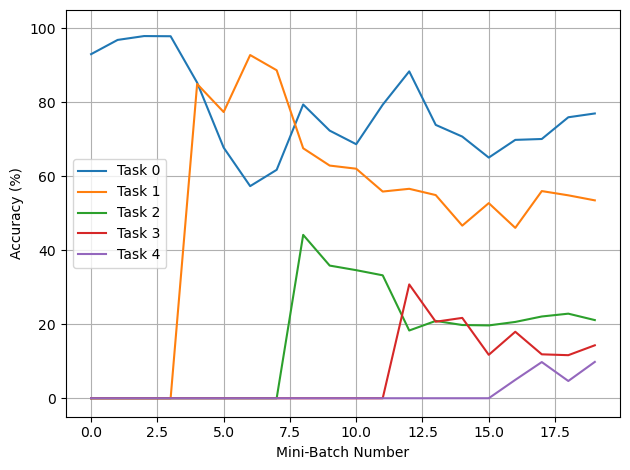

In [26]:
train_split_task("0", task_dataloaders)